In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

# K Nearest Neighbors Classifiers

So far we've covered learning via probability (naive Bayes) and learning via errors (regression). Here we'll cover learning via similarity. This means we look for the datapoints that are most similar to the observation we are trying to predict.

Let's start by the simplest example: **Nearest Neighbor**.

## Nearest Neighbor

Let's use this example: classifying a song as either "rock" or "jazz". For this data we have measures of duration in seconds and loudness in loudness units (we're not going to be using decibels since that isn't a linear measure, which would create some problems we'll get into later).

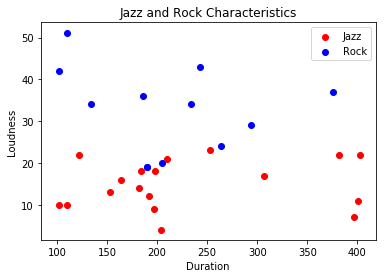

In [2]:
music = pd.DataFrame()

# Some data to play with.
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]

# We know whether the songs in our training data are jazz or not.
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]


# Look at our data.
plt.scatter(
    music[music['jazz'] == 1].duration,
    music[music['jazz'] == 1].loudness,
    color='red'
)
plt.scatter(
    music[music['jazz'] == 0].duration,
    music[music['jazz'] == 0].loudness,
    color='blue'
)
plt.legend(['Jazz', 'Rock'])
plt.title('Jazz and Rock Characteristics')
plt.xlabel('Duration')
plt.ylabel('Loudness')
plt.show()

The simplest form of a similarity model is the Nearest Neighbor model. This works quite simply: when trying to predict an observation, we find the closest (or _nearest_) known observation in our training data and use that value to make our prediction. Here we'll use the model as a classifier, the outcome of interest will be a category.

To find which observation is "nearest" we need some kind of way to measure distance. Typically we use _Euclidean distance_, the standard distance measure that you're familiar with from geometry. With one observation in n-dimensions $(x_1, x_2, ...,x_n)$ and the other $(w_1, w_2,...,w_n)$:

$$ \sqrt{(x_1-w_1)^2 + (x_2-w_2)^2+...+(x_n-w_n)^2} $$

You might recognize this formula, (taking distances, squaring them, adding the squares together, and taking the root) as a generalization of the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) into n-dimensions. You can technically define any distance measure you want, and there are times where this customization may be valuable. As a general standard, however, we'll use Euclidean distance.

Now that we have a distance measure from each point in our training data to the point we're trying to predict the model can find the datapoint with the smallest distance and then apply that category to our prediction.

Let's try running this model, using the SKLearn package.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a song with 24 loudness that's 190 seconds long.
neighbors.predict([[24, 190]])

array([0])

It's as simple as that. Looks like our model is predicting that 24 loudness, 190 second long song is _not_ jazz. All it takes to train the model is a dataframe of independent variables and a dataframe of dependent outcomes.

You'll note that for this example, we used the `KNeighborsClassifier` method from SKLearn. This is because Nearest Neighbor is a simplification of K-Nearest Neighbors. The jump, however, isn't that far.

## K-Nearest Neighbors

**K-Nearest Neighbors** (or "**KNN**") is the logical extension of Nearest Neighbor. Instead of looking at just the single nearest datapoint to predict an outcome, we look at several of the nearest neighbors, with $k$ representing the number of neighbors we choose to look at. Each of the $k$ neighbors gets to vote on what the predicted outcome should be.

This does a couple of valuable things. Firstly, it smooths out the predictions. If only one neighbor gets to influence the outcome, the model explicitly overfits to the training data. Any single outlier can create pockets of one category prediction surrounded by a sea of the other category.

This also means instead of just predicting classes, we get implicit probabilities. If each of the $k$ neighbors gets a vote on the outcome, then the probability of the test example being from any given class $i$ is:
$$ \frac{votes_i}{k} $$

And this applies for all classes present in the training set. Our example only has two classes, but this model can accommodate as many classes as the data set necessitates. To come up with a classifier prediction it simply takes the class for which that fraction is maximized.

Let's expand our initial nearest neighbors model from above to a KNN with a $k$ of 5.

In [4]:
neighbors = KNeighborsClassifier(n_neighbors=5)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a 24 loudness, 190 seconds long song.
print(neighbors.predict([[24, 190]]))
print(neighbors.predict_proba([[24, 190]]))

[1]
[[0.4 0.6]]


Now our test prediction has changed. In using the five nearest neighbors it appears that there were two votes for rock and three for jazz, so it was classified as a jazz song. This is different than our simpler Nearest Neighbors model. While the closest observation was in fact rock, there are more jazz songs in the nearest $k$ neighbors than rock.

We can visualize our decision bounds with something called a _mesh_. This allows us to generate a prediction over the whole space. Read the code below and make sure you can pull out what the individual lines do, consulting the documentation for unfamiliar methods if necessary.

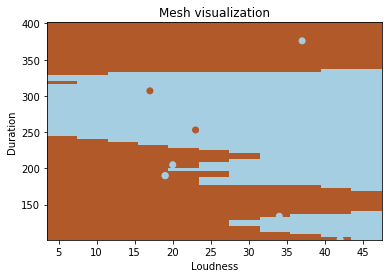

In [5]:
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 4.0

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

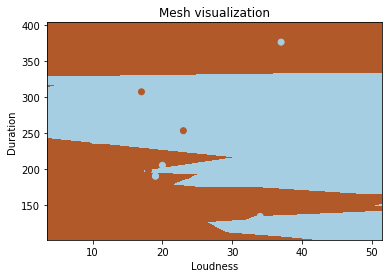

In [10]:
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 0.05

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

Looking at the visualization above, any new point that fell within a blue area would be predicted to be jazz, and any point that fell within a brown area would be predicted to be rock.

The boundaries above are strangly jagged here, and we'll get into that in more detail in the next lesson.

Also note that the visualization isn't completely continuous. There are an infinite number of points in this space, and we can't calculate the value for each one. That's where the mesh comes in. We set our mesh size (`h = 4.0`) to 4.0 above, which means we calculate the value for each point in a grid where the points are spaced 4.0 away from each other.

You can make the mesh size smaller to get a more continuous visualization, but at the cost of a more computationally demanding calculation. In the cell below, recreate the plot above with a mesh size of `10.0`. Then reduce the mesh size until you get a plot that looks good but still renders in a reasonable amount of time. When do you get a visualization that looks acceptably continuous? When do you start to get a noticeable delay?

In [6]:
# Play with different mesh sizes here.



Now you've built a KNN model!

## Challenge: Implement the Nearest Neighbor algorithm 

The Nearest Neighbor algorithm is extremely simple. So simple, in fact, that you should be able to build it yourself from scratch using the Python you already know. Code a Nearest Neighbors algorithm that works for two dimensional data. You can use either arrays or dataframes to do this. Test it against the SKLearn package on the music dataset from above to ensure that it's correct. The goal here is to confirm your understanding of the model and continue to practice your Python skills. We're just expecting a brute force method here. After doing this, look up "ball tree" methods to see a more performant algorithm design.

In [11]:
# Your nearest neighbor algorithm here.
music.head()


,duration,loudness,jazz
0,184,18,1
1,134,34,0
2,243,43,0
3,186,36,0
4,122,22,1


In [161]:
def distance(a,b,x,y):
    return np.sqrt((a-x)**2+(b-y)**2)

k_order = 1

def the_closest_points(a,b,df,k_order):
    distance_serie = distance(a,b,df.duration,df.loudness)
    the_limit = distance_serie.sort_values(ascending=True)[:k_order].max()
    return distance_serie[distance_serie<=the_limit]

def manual_knn(a,b,df,k_order):
    return int(music[music.index.isin(the_closest_points(a,b,music,k_order).index)].jazz.mean()>=0.5)


In [164]:
for _ in range(500):
    duration, loudness = np.random.randint(100,400), np.random.randint(1,50)
    manuel = manual_knn(duration,loudness,music,5)
    predicted = neighbors.predict(np.c_[loudness,duration])[0]
    if manuel != predicted:
        print(duration,loudness,manuel,predicted)

235 11 1 0
186 32 1 0


Over 500 points selected at random, we still have 1 or 2 discrepencies, but those are due to points that are equidistant around the k limit (meaning for k= 5, both point in 5 and 6 are at the same distance).